## Dependencies

In [18]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix

vader = SentimentIntensityAnalyzer()

### Load dataset

In [2]:
df = pd.read_csv(r"../data/processed/top_150_fantasy_reviews_cleaned.csv")
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,total_reactions,nice_count,love_it_count,funny_count,confusing_count,informative_count,well_written_count,creative_count,review_sentiment,review_nerpos
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,1347,281,833,44,58,5,124,2,with lives so short why do we even bother? to...,"With lives so short, why do we even bother? To..."
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,1211,248,789,43,50,8,70,3,i feel so catered to it feels like an eternit...,I feel so catered to. It feels like an eternit...
2,519472,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519472,"Mar 24, 2024 2:03 AM",Trikkiez,3,False,NaN,Not Recommended,4,...,4219,630,105,1966,1355,29,123,11,style frieren does not have its own unique st...,Style- Frieren does not have its own unique st...
3,512466,Sousou no Frieren,https://myanimelist.net/reviews.php?id=512466,"Jan 12, 2024 11:25 AM",ShabbaRico,12,True,18/28,Not Recommended,5,...,931,183,28,400,267,9,42,2,tl dr 5 10 i do not recommend this for anyon...,"TL;DR: 5/10, I do not recommend this for anyon..."
4,503760,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503760,"Oct 13, 2023 9:10 AM",TheRealist68,16,True,6/28,Mixed Feelings,9,...,953,412,60,31,314,10,122,4,through 3 episodes frieren appears to be a un...,"Through 3 episodes, Frieren appears to be a un..."


## TextBlob Sentiment Analysis

In [3]:
def get_textblob_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({
        "textblob_polarity": blob.sentiment.polarity,
        "textblob_subjectivity": blob.sentiment.subjectivity
    })

df[['textblob_polarity', 'textblob_subjectivity']] = df['review_sentiment'].apply(get_textblob_sentiment)

In [4]:
def label_polarity(p):
    if p > 0.1:
        return 'positive'
    elif p < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['textblob_label'] = df['textblob_polarity'].apply(label_polarity)

In [5]:
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,funny_count,confusing_count,informative_count,well_written_count,creative_count,review_sentiment,review_nerpos,textblob_polarity,textblob_subjectivity,textblob_label
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,44,58,5,124,2,with lives so short why do we even bother? to...,"With lives so short, why do we even bother? To...",0.087698,0.506092,neutral
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,43,50,8,70,3,i feel so catered to it feels like an eternit...,I feel so catered to. It feels like an eternit...,0.188848,0.523496,positive
2,519472,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519472,"Mar 24, 2024 2:03 AM",Trikkiez,3,False,NaN,Not Recommended,4,...,1966,1355,29,123,11,style frieren does not have its own unique st...,Style- Frieren does not have its own unique st...,-0.000063,0.544437,neutral
3,512466,Sousou no Frieren,https://myanimelist.net/reviews.php?id=512466,"Jan 12, 2024 11:25 AM",ShabbaRico,12,True,18/28,Not Recommended,5,...,400,267,9,42,2,tl dr 5 10 i do not recommend this for anyon...,"TL;DR: 5/10, I do not recommend this for anyon...",0.074623,0.449968,neutral
4,503760,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503760,"Oct 13, 2023 9:10 AM",TheRealist68,16,True,6/28,Mixed Feelings,9,...,31,314,10,122,4,through 3 episodes frieren appears to be a un...,"Through 3 episodes, Frieren appears to be a un...",0.136992,0.483176,positive


## Vader Sentiment Analysis

In [6]:
def get_vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return pd.Series({
        'vader_neg': scores['neg'],
        'vader_neu': scores['neu'],
        'vader_pos': scores['pos'],
        'vader_compound': scores['compound']
    })

df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = df['review_sentiment'].apply(get_vader_sentiment)

In [7]:
def label_vader(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_label'] = df['vader_compound'].apply(label_vader)

In [8]:
df.head()

,review_id,anime_title,review_url,date,username,user_review_count,is_preliminary,episodes_watched,recommendation,rating,...,review_sentiment,review_nerpos,textblob_polarity,textblob_subjectivity,textblob_label,vader_neg,vader_neu,vader_pos,vader_compound,vader_label
0,503754,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503754,"Oct 13, 2023 8:38 AM",Czekaj,5,True,5/28,Recommended,10,...,with lives so short why do we even bother? to...,"With lives so short, why do we even bother? To...",0.087698,0.506092,neutral,0.068,0.853,0.079,0.8890,positive
1,519189,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519189,"Mar 22, 2024 12:40 PM",chekkit,25,False,NaN,Recommended,10,...,i feel so catered to it feels like an eternit...,I feel so catered to. It feels like an eternit...,0.188848,0.523496,positive,0.051,0.757,0.192,0.9987,positive
2,519472,Sousou no Frieren,https://myanimelist.net/reviews.php?id=519472,"Mar 24, 2024 2:03 AM",Trikkiez,3,False,NaN,Not Recommended,4,...,style frieren does not have its own unique st...,Style- Frieren does not have its own unique st...,-0.000063,0.544437,neutral,0.096,0.782,0.122,0.9958,positive
3,512466,Sousou no Frieren,https://myanimelist.net/reviews.php?id=512466,"Jan 12, 2024 11:25 AM",ShabbaRico,12,True,18/28,Not Recommended,5,...,tl dr 5 10 i do not recommend this for anyon...,"TL;DR: 5/10, I do not recommend this for anyon...",0.074623,0.449968,neutral,0.062,0.823,0.115,0.9991,positive
4,503760,Sousou no Frieren,https://myanimelist.net/reviews.php?id=503760,"Oct 13, 2023 9:10 AM",TheRealist68,16,True,6/28,Mixed Feelings,9,...,through 3 episodes frieren appears to be a un...,"Through 3 episodes, Frieren appears to be a un...",0.136992,0.483176,positive,0.036,0.818,0.146,0.9981,positive


### Save Cleaned Dataset

In [9]:
df.to_csv(r'../data/processed/top_150_fantasy_reviews_sentiment.csv', index=False)

## TextBlob Visualization

#### Jumlah Review per Label Sentimen TextBlob

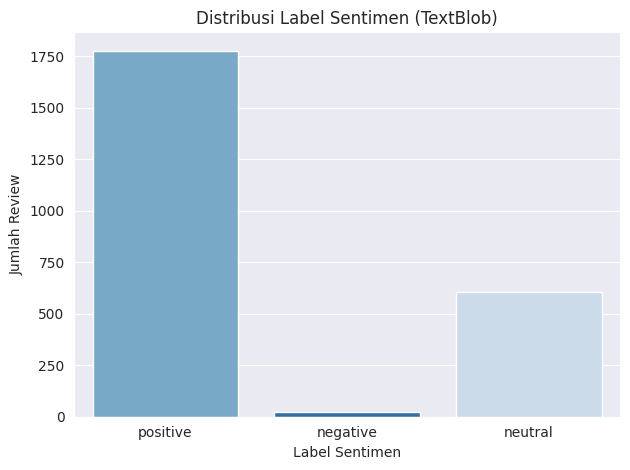

In [17]:
sns.countplot(data=df, x='textblob_label', order=['positive', 'negative', 'neutral'], palette='Blues', hue='textblob_label')
plt.title('Distribusi Label Sentimen (TextBlob)')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

#### Perbandingan Distribusi Nilai Polaritas TextBlob

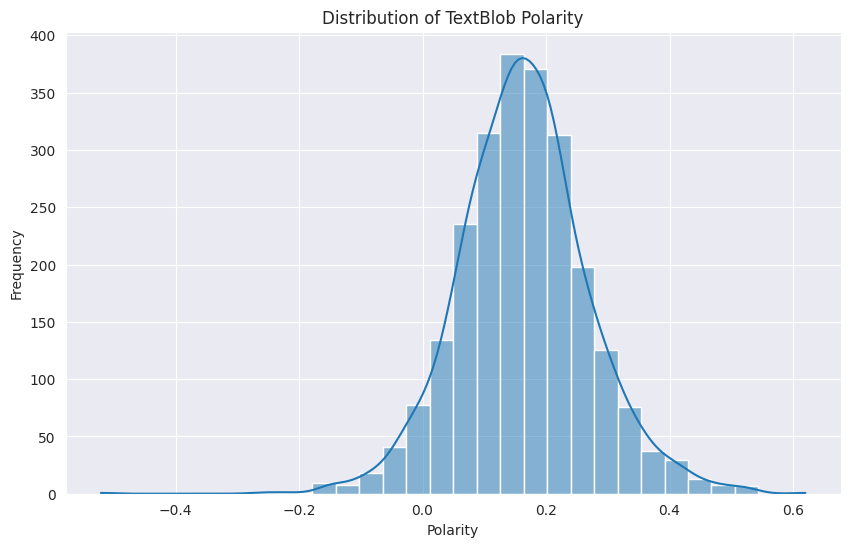

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['textblob_polarity'], bins=30, kde=True)
plt.title('Distribution of TextBlob Polarity')
plt.xlabel('Polarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Perbandingan Hasil TextBlob dengan Rekomendasi Actual

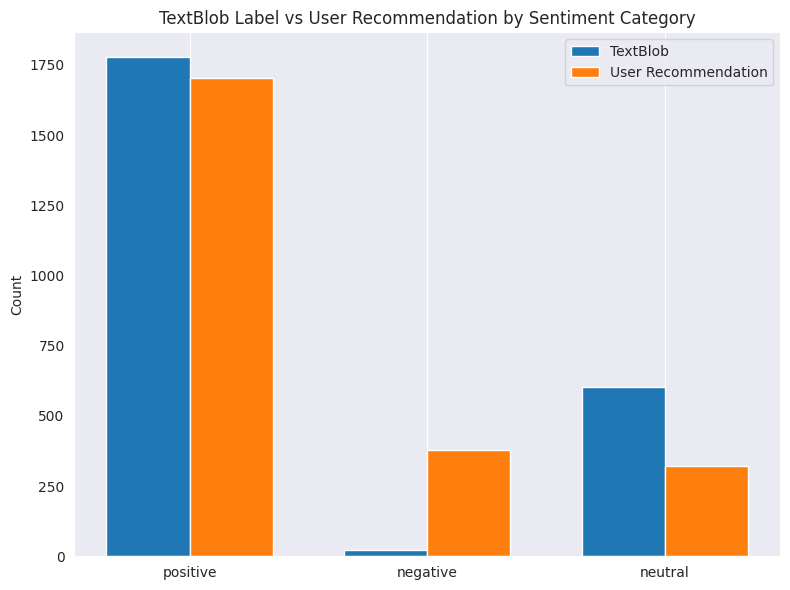

recommendation
Recommended        1704
Not Recommended     378
Mixed Feelings      321
Name: count, dtype: int64


In [16]:
categories = ['positive', 'negative', 'neutral']
matched_recommendations = ['Recommended', 'Not Recommended', 'Mixed Feelings']

textblob_counts = [df[df['textblob_label'] == cat].shape[0] for cat in categories]
recommendation_counts = [
    df[df['recommendation'] == rec].shape[0] for rec in matched_recommendations
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, textblob_counts, width, label='TextBlob')
bars2 = ax.bar(x + width/2, recommendation_counts, width, label='User Recommendation')

# Formatting
ax.set_ylabel('Count')
ax.set_title('TextBlob Label vs User Recommendation by Sentiment Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()

print(df["recommendation"].value_counts())

## Vader Visualization

#### Jumlah Review per Label Sentimen Vader


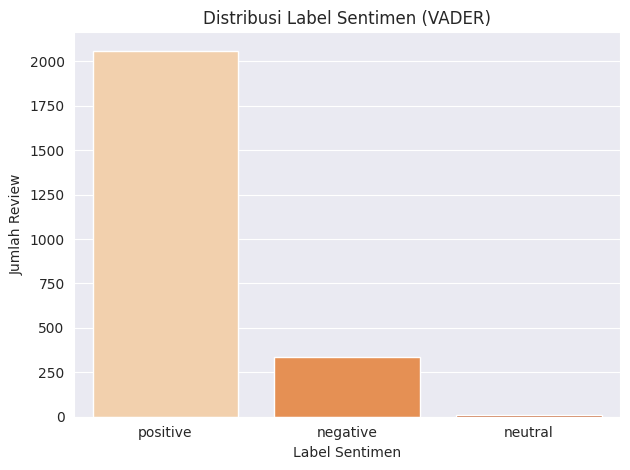

In [27]:
sns.countplot(data=df, x='vader_label', order=['positive', 'negative', 'neutral'], palette='Oranges', hue='vader_label')
plt.title('Distribusi Label Sentimen (VADER)')
plt.xlabel('Label Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

#### Perbandingan Distribusi Nilai Compound VADER

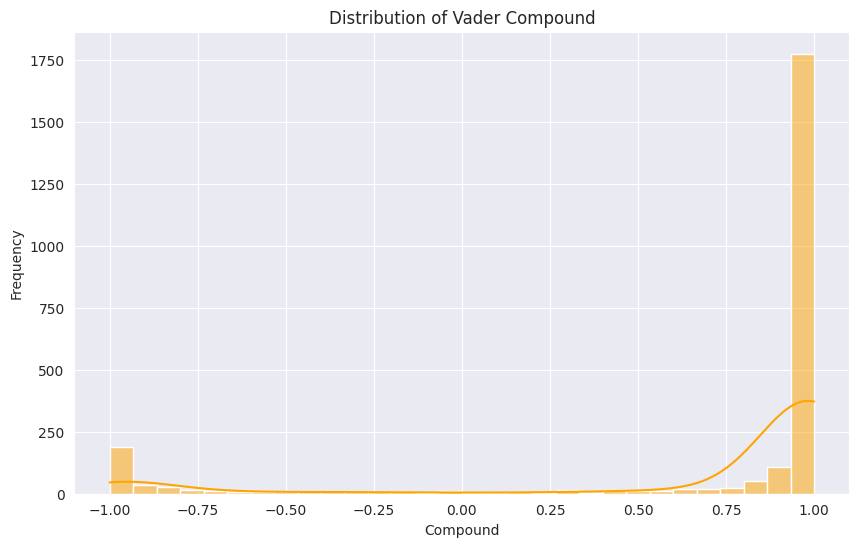

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(df['vader_compound'], bins=30, kde=True, color='orange')
plt.title('Distribution of VADER Compound')
plt.xlabel('Compound')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Perbandingan Hasil VADER dengan Rekomendasi Actual

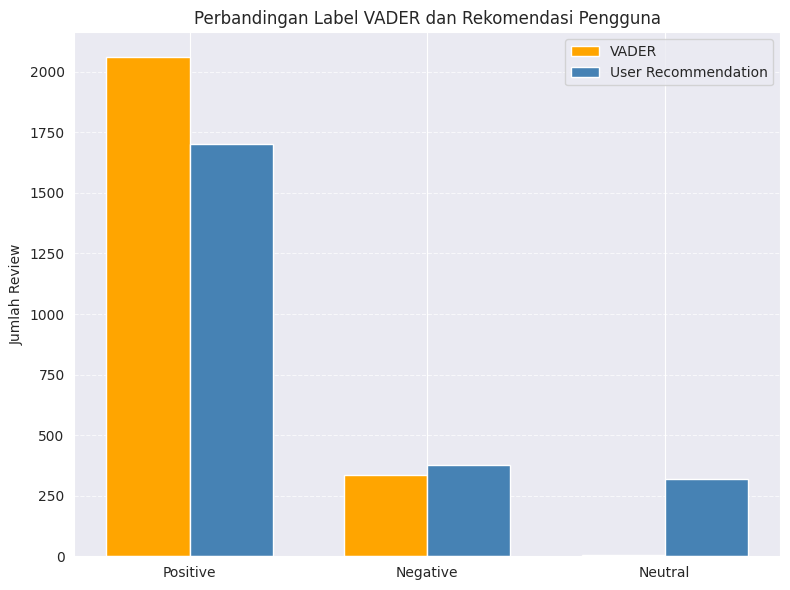

In [42]:
categories = ['positive', 'negative', 'neutral']
matched_recommendations = ['Recommended', 'Not Recommended', 'Mixed Feelings']

vader_counts = [df[df['vader_label'] == cat].shape[0] for cat in categories]
recommendation_counts = [
    df[df['recommendation'] == rec].shape[0] for rec in matched_recommendations
]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, vader_counts, width, label='VADER', color='#FFA500')  # Orange
bars2 = ax.bar(x + width/2, recommendation_counts, width, label='User Recommendation', color='#4682B4')  # Steel Blue

ax.set_ylabel('Jumlah Review')
ax.set_title('Perbandingan Label VADER dan Rekomendasi Pengguna')
ax.set_xticks(x)
ax.set_xticklabels(['Positive', 'Negative', 'Neutral'])
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## TextBlob vs VADER Results

#### Classification Report F1

In [43]:
def map_recommendation(rec):
    if rec == 'Recommended':
        return 'positive'
    elif rec == 'Not Recommended':
        return 'negative'
    else:
        return 'neutral'

df['recommendation_mapped'] = df['recommendation'].apply(map_recommendation)

print("=== Evaluation for TextBlob ===")
print(classification_report(df['recommendation_mapped'], df['textblob_label'], digits=3))

print("=== Evaluation for VADER ===")
print(classification_report(df['recommendation_mapped'], df['vader_label'], digits=3))

=== Evaluation for TextBlob ===
              precision    recall  f1-score   support

    negative      0.727     0.042     0.080       378
     neutral      0.252     0.474     0.329       321
    positive      0.855     0.892     0.873      1704

    accuracy                          0.702      2403
   macro avg      0.611     0.469     0.427      2403
weighted avg      0.755     0.702     0.676      2403

=== Evaluation for VADER ===
              precision    recall  f1-score   support

    negative      0.562     0.500     0.529       378
     neutral      0.286     0.006     0.012       321
    positive      0.791     0.956     0.866      1704

    accuracy                          0.757      2403
   macro avg      0.546     0.487     0.469      2403
weighted avg      0.687     0.757     0.699      2403



#### Confusion Matrix Visualization

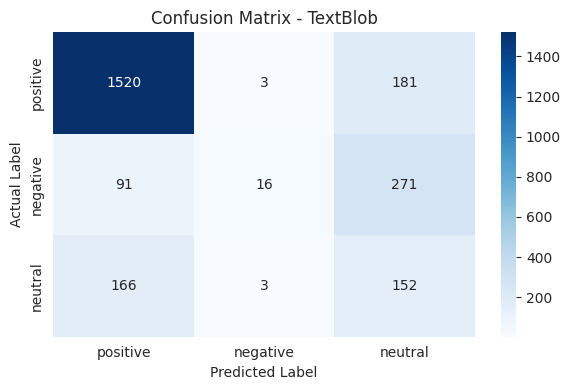

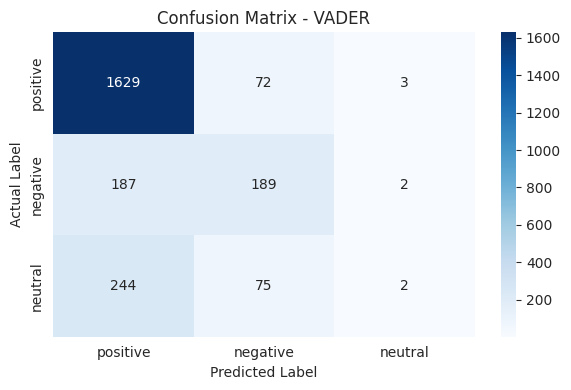

In [45]:
label_map = {
    'Recommended': 'positive',
    'Not Recommended': 'negative',
    'Mixed Feelings': 'neutral'
}

df['recommendation_sentiment'] = df['recommendation'].map(label_map)

cm_textblob = confusion_matrix(df['recommendation_sentiment'], df['textblob_label'], labels=['positive', 'negative', 'neutral'])
cm_vader = confusion_matrix(df['recommendation_sentiment'], df['vader_label'], labels=['positive', 'negative', 'neutral'])

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['positive', 'negative', 'neutral'],
                yticklabels=['positive', 'negative', 'neutral'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_textblob, "Confusion Matrix - TextBlob")

plot_confusion_matrix(cm_vader, "Confusion Matrix - VADER")